In [1]:
# from google.colab import files
# files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d wobotintelligence/face-mask-detection-dataset
!rm kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/wobotintelligence/face-mask-detection-dataset
License(s): CC0-1.0
100% 2.49G/2.50G [00:37<00:00, 134MB/s]
100% 2.50G/2.50G [00:37<00:00, 71.4MB/s]
rm: cannot remove 'kaggle.json': No such file or directory


In [2]:
!unzip face-mask-detection-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Medical mask/Medical mask/Medical Mask/images/1091.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1092.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1093.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1094.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1095.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1096.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1097.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1098.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1099.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1101.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1102.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1103.png  
  inflating: Medical mask/Medical mask/Medical Mask/images/1104.jpg  
  inflating: Medical mask/Medical mask/

In [3]:
!rm -rf sample_data

In [4]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.7 MB/s eta 0:00:00


# Basic Imports

In [5]:
import os
import csv
import cv2
import json
import random
import pprint as pp
import matplotlib.pyplot as plt

# Preprocssing

In [6]:
BASE_DIR = 'Medical mask/Medical mask/Medical Mask'
IMAGE_DIR = os.path.join(BASE_DIR, 'images')
ANNOTATIONS_DIR = os.path.join(BASE_DIR, 'annotations')

In [7]:
for file in os.listdir(ANNOTATIONS_DIR):
  with open(os.path.join(ANNOTATIONS_DIR, file), 'r') as f:
    data = json.load(f)
    pp.pprint(data)
    break

{'Annotations': [{'Attributes': {},
                  'BoundingBox': [55, 53, 289, 386],
                  'Confidence': 1,
                  'ID': 396739480179795328,
                  'classname': 'face_with_mask',
                  'isProtected': False},
                 {'Attributes': {},
                  'BoundingBox': [108, 190, 280, 378],
                  'Confidence': 1,
                  'ID': 258176738026431936,
                  'classname': 'mask_colorful',
                  'isProtected': False}],
 'FileName': '2403.png',
 'NumOfAnno': 2}


In [8]:
faces_with_mask = []
faces_without_mask = []

with open('train.csv', 'r') as f:
  data = list(csv.reader(f))

  faces_with_mask = list(filter(lambda x: x[5] == 'face_with_mask', data[1:]))
  faces_without_mask = list(filter(lambda x: x[5] == 'face_no_mask', data[1:]))

random.shuffle(faces_with_mask)
random.shuffle(faces_without_mask)

print(len(faces_with_mask), len(faces_without_mask))

4180 1569


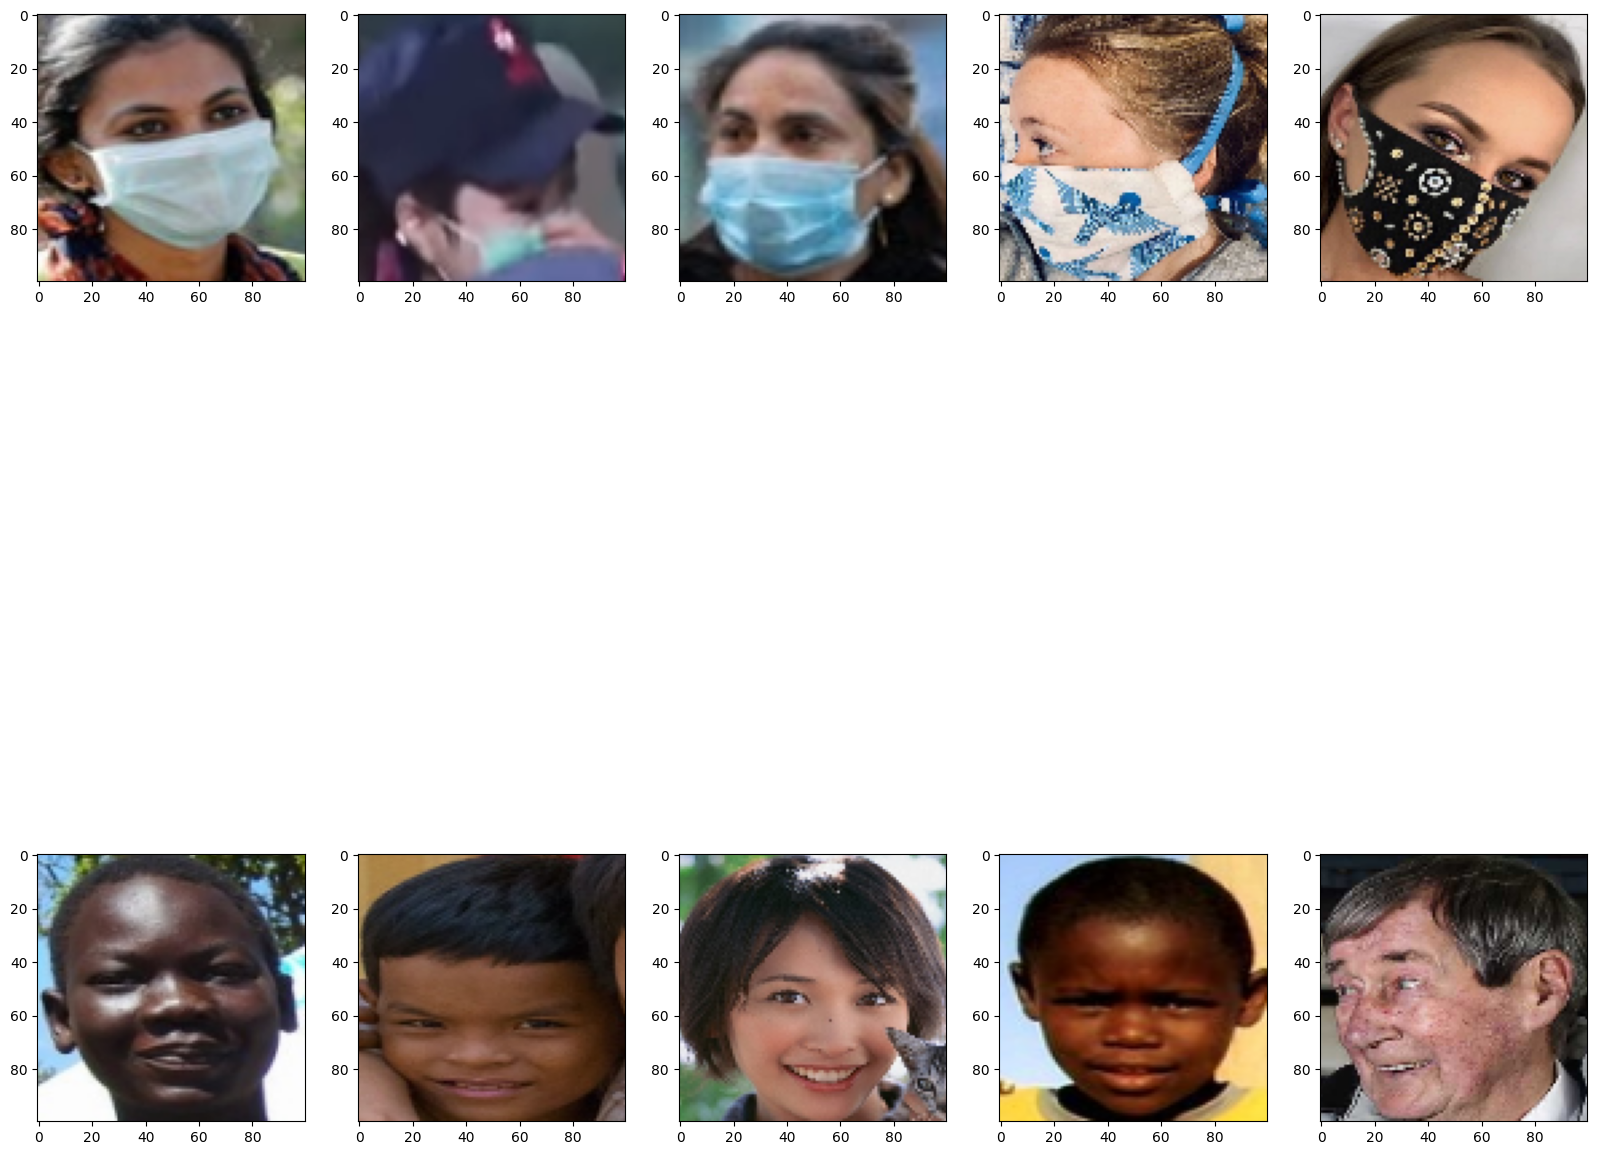

In [9]:
# Viewing data

fig, ax = plt.subplots(2, 5, figsize=(20, 20))

for i, face in enumerate(faces_with_mask[:5]):
  image = cv2.cvtColor(cv2.imread(os.path.join(IMAGE_DIR, face[0])), cv2.COLOR_BGR2RGB)
  start = int(face[1]), int(face[2])
  end = int(face[3]), int(face[4])
  image = image[start[1]:end[1], start[0]:end[0]]
  image = cv2.resize(image, (100, 100))
  ax[0, i].imshow(image)

for i, face in enumerate(faces_without_mask[:5]):
  image = cv2.cvtColor(cv2.imread(os.path.join(IMAGE_DIR, face[0])), cv2.COLOR_BGR2RGB)
  start = int(face[1]), int(face[2])
  end = int(face[3]), int(face[4])
  image = image[start[1]:end[1], start[0]:end[0]]
  image = cv2.resize(image, (100, 100))
  ax[1, i].imshow(image)
fig.show()

In [10]:
X = []
y = []

for i, cat in enumerate((faces_without_mask, faces_with_mask)):
  for f in cat:
    image = cv2.cvtColor(cv2.imread(os.path.join(IMAGE_DIR, f[0])), cv2.COLOR_BGR2RGB)
    start = int(f[1]), int(f[2])
    end = int(f[3]), int(f[4])
    image = image[start[1]:end[1], start[0]:end[0]]
    image = cv2.resize(image, (100, 100))
    X.append(image)
    y.append(i)

print(len(X))
print(len(y))

5749
5749


5174 575


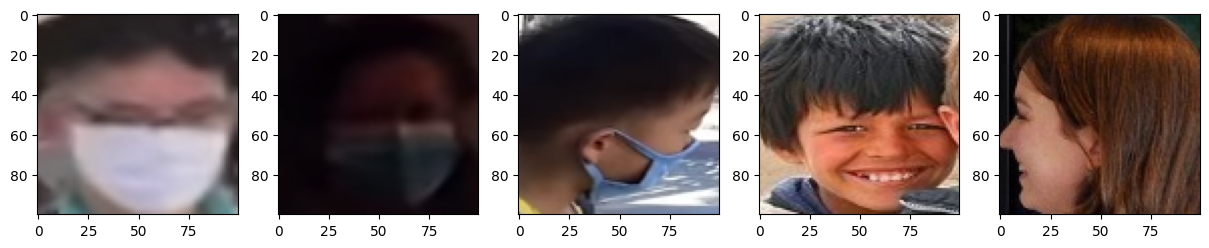

In [11]:
# Splitting the data for training and testing
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input

# X_new = []

# for i, img in enumerate(X):
#   X_new.append(preprocess_input(img))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


print(len(X_train), len(X_test))

# Viewing trainning datas
fig, ax = plt.subplots(1, 5, figsize=(15, 15))

for i, img in enumerate(X_train[:5]):
  ax[i].imshow(img)
fig.show()

X_train = np.array(X_train, dtype='float32')
y_train = np.array(y_train)
X_test = np.array(X_test, dtype='float32')
y_test = np.array(y_test)

# Creating model architecture

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam


base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(100, 100, 3)), classes=1)

new_model = base_model.output
new_model = Flatten()(new_model)
new_model = Dense(256, activation='relu')(new_model)
new_model = Dense(1, activation='sigmoid')(new_model)

for layer in base_model.layers:
  layer.trainable = False

model = Model(inputs=base_model.input, outputs=new_model)
opt = Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy' ,optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,894,849 (60.63 MB)

 Trainable params: 1,180,161 (4.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Training

In [14]:
EPOCHS = 5

history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.1)

Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.8578 - loss: 1.0549 - val_accuracy: 0.9035 - val_loss: 0.6568
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9717 - loss: 0.1220 - val_accuracy: 0.9266 - val_loss: 0.4873
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9930 - loss: 0.0208 - val_accuracy: 0.9363 - val_loss: 0.5093
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9286 - val_loss: 0.5534
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 1.0000 - loss: 9.0678e-04 - val_accuracy: 0.9402 - val_loss: 0.4938


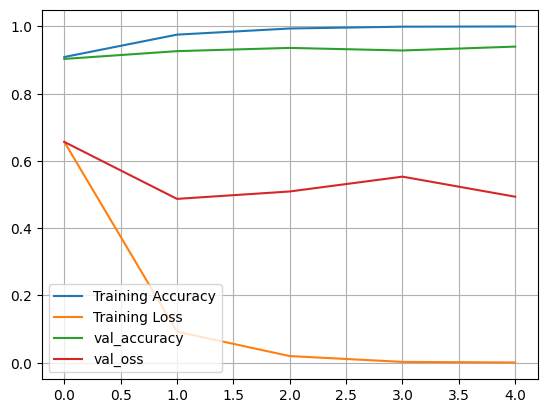

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.9571 - loss: 0.2672


0.947826087474823

In [15]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_loss'], label='val_oss')
plt.grid()
plt.legend()
plt.show()

losss, acc = model.evaluate(X_test, y_test)
acc

In [22]:
model.save('model.h5')
model.save('model.keras')

In [24]:
model = tf.keras.models.load_model('model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


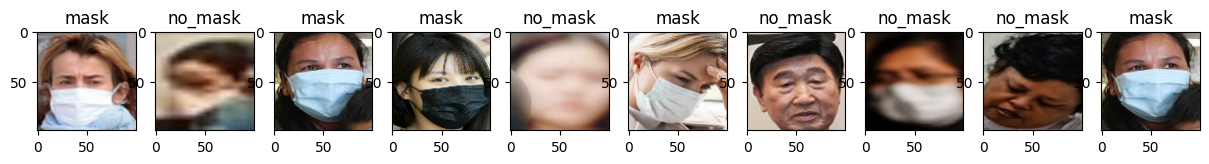

In [17]:
# from google.colab.patches import cv2_imshow
import tensorflow as tf

cat = ('no_mask', 'mask')
fig, ax = plt.subplots(1, 10, figsize=(15, 15))

model = tf.keras.models.load_model('model.h5')

for i in range(10):
  image = random.choice(X_test)
  predictions = model.predict(image.reshape(-1, 100, 100, 3))
  title = cat[int(predictions[0][0])]

  ax[i].imshow(image.astype('uint32'))
  ax[i].title.set_text(title)

fig.show()

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def predict(model, image):
  prediction = model.predict(image.reshape(-1, 100, 100, 3))[0][0]
  return int(round(prediction, 1))

predict_array = [predict(model, image) for image in X_test]

results = confusion_matrix(y_test, predict_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

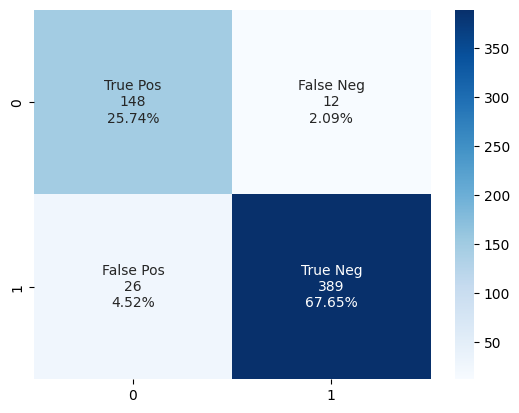

In [19]:
group_names = ["True Pos","False Neg","False Pos","True Neg"]
group_counts = ['{0:0.0f}'.format(value) for value in
                results.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     results.flatten()/np.sum(results)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(results, annot=labels, fmt='', cmap='Blues')
plt.show()